### Imports & Logging Setup

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import logging

# Machine Learning
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer

# Suppress warnings
warnings.simplefilter("ignore")

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features

In [8]:
import pandas as pd
import os
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File paths
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "chi_squared": "../results/chi_squared_features.csv",
    "information_gain": "../results/information_gain_results.csv",
    "lasso": "../results/lasso_results.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load and extract selected miRNAs
def load_selected_miRNAs(file_paths, num_features=10):
    feature_sets = {}

    for key, path in file_paths.items():
        if key == "processed_data":
            continue  # Skip processed data file

        if os.path.exists(path):
            df = pd.read_csv(path)
            if key == "fold_change" and "log2_fold_change" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "log2_fold_change")["Unnamed: 0"])
            elif key == "chi_squared" and "Score" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Score")["Feature"])
            elif key == "information_gain" and "Info_Gain_General" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Info_Gain_General")["Feature"])
            elif key == "lasso" and "Coefficient" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Coefficient")["Feature"])
            else:
                logging.warning(f"Unexpected format in {key}, skipping.")
        else:
            logging.warning(f"Feature selection file missing: {path}")

    # Combine features correctly (preserve all miRNAs before filtering)
    combined_features = []
    for feature_set in feature_sets.values():
        combined_features.extend(list(feature_set))  # Keep all miRNAs before filtering

    # Remove duplicates by converting to a set, then back to a list
    unique_miRNAs = list(set(combined_features))
    logging.info(f"Total unique miRNAs after merging feature selection methods: {len(unique_miRNAs)}")

    return unique_miRNAs

# Load processed data
if os.path.exists(file_paths["processed_data"]):
    processed_data = pd.read_csv(file_paths["processed_data"])
else:
    raise FileNotFoundError(f"Processed data file missing: {file_paths['processed_data']}")

# Create a binary diagnosis column
processed_data["diagnosis"] = processed_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Select top features
num_features_to_select = 10
selected_miRNAs = load_selected_miRNAs(file_paths, num_features=num_features_to_select)

# **Fix: Remove non-miRNA entries (like 'stage' and 'subtype')**
cleaned_miRNAs = [miRNA for miRNA in selected_miRNAs if miRNA.startswith("hsa-mir-")]

# **Restore `top_features` for compatibility**
top_features = cleaned_miRNAs  # Ensure compatibility with next block

# Final Check: Ensure count matches actual miRNAs displayed
print("\nCleaned miRNAs Used in Classification:")
for i, miRNA in enumerate(cleaned_miRNAs, 1):
    print(f"{i}. {miRNA}")

print(f"\nFinal count of selected miRNAs: {len(cleaned_miRNAs)}")  # Ensures the number matches printout

# Save cleaned miRNAs to a new CSV file
cleaned_miRNAs_df = pd.DataFrame(cleaned_miRNAs, columns=["Selected_miRNAs"])
cleaned_miRNAs_df.to_csv("../results/cleaned_selected_miRNAs.csv", index=False)

# Define target columns (diagnosis is used for classification)
target_columns = ["diagnosis"]  

# **Ensure 'stage' and 'subtype' remain as metadata (titles only)**
metadata_columns = ["stage", "subtype"]

# **Feature Engineering: Extract relevant columns for modeling**
selected_features = cleaned_miRNAs + target_columns
filtered_data = processed_data[selected_features + metadata_columns]  # Keep 'stage' and 'subtype' in dataset

# **Scale features (excluding metadata)**
scaler = StandardScaler()
scaled_features = scaler.fit_transform(filtered_data.drop(columns=metadata_columns + target_columns))
scaled_df = pd.DataFrame(scaled_features, columns=cleaned_miRNAs)

# **Reattach 'stage', 'subtype', and 'diagnosis' without scaling**
scaled_df[target_columns + metadata_columns] = filtered_data[target_columns + metadata_columns]

# **Split dataset into train/test**
X = scaled_df.drop(columns=target_columns)  # Only miRNA features go into X
y = scaled_df["diagnosis"]  # Change target as needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save cleaned and processed data for modeling
scaled_df.to_csv("../processed_data/scaled_miRNA_data.csv", index=False)
logging.info("Cleaned and processed miRNA dataset saved.")

print("\nData preprocessing complete. Ready for classification.")


2025-02-07 12:44:36,387 - INFO - Total unique miRNAs after merging feature selection methods: 39
2025-02-07 12:44:36,448 - INFO - Cleaned and processed miRNA dataset saved.



Cleaned miRNAs Used in Classification:
1. hsa-mir-520e
2. hsa-mir-520d
3. hsa-mir-187
4. hsa-mir-5690
5. hsa-mir-8082
6. hsa-mir-181d
7. hsa-mir-518f
8. hsa-mir-4300
9. hsa-mir-3661
10. hsa-mir-1253
11. hsa-mir-509-1
12. hsa-mir-520h
13. hsa-mir-523
14. hsa-mir-203b
15. hsa-mir-4663
16. hsa-mir-1825
17. hsa-mir-4731
18. hsa-mir-6766
19. hsa-mir-3973
20. hsa-mir-4637
21. hsa-mir-185
22. hsa-mir-571
23. hsa-mir-526a-2
24. hsa-mir-548ak
25. hsa-mir-5583-1
26. hsa-mir-451b
27. hsa-mir-6071
28. hsa-mir-519d
29. hsa-mir-1283-2
30. hsa-mir-1181
31. hsa-mir-515-2
32. hsa-mir-3922
33. hsa-mir-524
34. hsa-mir-4257
35. hsa-mir-8066
36. hsa-mir-631
37. hsa-mir-760

Final count of selected miRNAs: 37

Data preprocessing complete. Ready for classification.


### Process Features & Labels for Multi-Output Classification

In [9]:
def process_features_and_labels(processed_data, selected_features):
    """
    Filters processed data for selected features and extracts multi-output target labels.
    
    Args:
        processed_data (pd.DataFrame): Data containing features and target variables.
        selected_features (list): List of feature names to filter.

    Returns:
        tuple: Processed feature dataframe (X) and label dataframe (y).
    """
    # Check for missing features
    missing_features = [f for f in selected_features if f not in processed_data.columns]
    if missing_features:
        logging.warning(f"{len(missing_features)} features missing from dataset! Missing: {missing_features}")

    # Stop if more than 50% of features are missing
    missing_ratio = len(missing_features) / len(selected_features)
    if missing_ratio > 0.5:
        raise ValueError(f"More than 50% of selected features are missing! ({missing_ratio * 100:.2f}%)")

    # Keep only available features
    selected_features = [f for f in selected_features if f in processed_data.columns]

    # Extract features and ensure numeric values
    X = processed_data[selected_features].apply(pd.to_numeric, errors='coerce')

    # Extract labels
    y = processed_data[["diagnosis", "stage", "subtype"]]

    # Check for missing values
    if X.isnull().values.any() or y.isnull().values.any():
        logging.warning("Missing values detected in features or labels.")

        # Print summary of missing values
        print("\n Missing values per feature (Top 5):")
        missing_counts = X.isnull().sum()
        print(missing_counts[missing_counts > 0].head())

        print("\n Missing values in labels:")
        print(y.isnull().sum())

        # Drop rows with missing values
        valid_indices = ~(X.isnull().any(axis=1) | y.isnull().any(axis=1))
        X = X[valid_indices]
        y = y[valid_indices]

    # Standardize feature values
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    logging.info("Features have been standardized.")

    # Train-Test Split (No SMOTE, just stratified sampling)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y["diagnosis"])

    # Log dataset details
    logging.info(f"Training Set Shape: {X_train.shape}")
    logging.info(f"Test Set Shape: {X_test.shape}")
    logging.info(f"Class distribution in training set:\n{y_train['diagnosis'].value_counts(normalize=True)}")

    return X_train, X_test, y_train, y_test

# Process features and labels
X_train, X_test, y_train, y_test = process_features_and_labels(processed_data, top_features)

# Debugging: Check the prepared data
print("\nExpression values sample:")
print(X_train.head())

print("\nFeature statistics:")
print(X_train.describe())

print("\nClass proportions in train set:")
print(y_train["diagnosis"].value_counts(normalize=True))

2025-02-07 12:44:38,660 - INFO - Features have been standardized.
2025-02-07 12:44:38,664 - INFO - Training Set Shape: (872, 37)
2025-02-07 12:44:38,666 - INFO - Test Set Shape: (219, 37)
2025-02-07 12:44:38,668 - INFO - Class distribution in training set:
diagnosis
1    0.989679
0    0.010321
Name: proportion, dtype: float64



Expression values sample:
     hsa-mir-520e  hsa-mir-520d  hsa-mir-187  hsa-mir-5690  hsa-mir-8082  \
459     -0.045254     -0.059336    -0.463482      0.614769     -0.030289   
765     -0.045254     -0.059336    -0.166884     -0.706293     -0.030289   
749     -0.045254     -0.059336    -0.457531      3.280114     -0.030289   
990     -0.045254     -0.059336    -0.023606     -0.706293     -0.030289   
270     -0.045254     -0.059336    -0.298095     -0.429187     -0.030289   

     hsa-mir-181d  hsa-mir-518f  hsa-mir-4300  hsa-mir-3661  hsa-mir-1253  \
459     -0.508012     -0.045815     -0.042693     -0.196478     -0.042615   
765      0.093967     -0.049625     -0.042693     -0.196478     -0.042615   
749     -0.121647     -0.049625     -0.042693     -0.196478     -0.042615   
990     -0.803903     -0.049625     -0.042693     -0.196478     -0.042615   
270     -0.084988     -0.048826     -0.042693     -0.196478     -0.042615   

     ...  hsa-mir-519d  hsa-mir-1283-2  hsa-mir-1181 

### Train-Test Split & Feature Scaling

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Remove rare cases from dataset before train-test split
rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove

# Create a mask to filter out rare cases
filtered_data = processed_data[~processed_data.set_index(["stage", "subtype"]).index.isin(rare_cases)].copy()

# Remove subtype 4 before splitting (since it only has 1 sample)
filtered_data = filtered_data[filtered_data["subtype"] != 4]

# Ensure Diagnosis column is also updated after filtering
filtered_data["diagnosis"] = filtered_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Extract features and target labels again
expression_values = filtered_data[top_features]

# Train-Test Split for Diagnosis Model (Healthy vs. Cancer)
X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis = train_test_split(
    expression_values, filtered_data["diagnosis"], test_size=0.2, random_state=42, stratify=filtered_data["diagnosis"]
)

# Train-Test Split for Stage & Subtype (Only Cancer Patients)
cancer_only = filtered_data["diagnosis"] == 1  # Filter out healthy cases
X_cancer = expression_values[cancer_only]
y_cancer = filtered_data[cancer_only][["stage", "subtype"]]

# Verify updated class distribution
print("\nUpdated class distribution for 'subtype':")
print(y_cancer["subtype"].value_counts())

# Check class distribution before stratifying
print("\nClass distribution in cancer dataset before splitting:")
print(y_cancer.value_counts())

# Check if all classes have at least 2 samples
min_class_size = y_cancer.apply(pd.Series.value_counts).min().min()

if min_class_size < 2:
    print("\nSome classes have too few samples for stratified splitting. Using random split instead.")
    stratify_option = None
else:
    stratify_option = y_cancer

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=stratify_option
)

# Scale features AFTER train-test split
scaler = StandardScaler()
X_train_diagnosis = scaler.fit_transform(X_train_diagnosis)
X_test_diagnosis = scaler.transform(X_test_diagnosis)

X_train_cancer = scaler.fit_transform(X_train_cancer)
X_test_cancer = scaler.transform(X_test_cancer)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Diagnosis Model - Training set: {X_train_diagnosis.shape}, Testing set: {X_test_diagnosis.shape}")
print(f"Stage & Subtype Model - Training set: {X_train_cancer.shape}, Testing set: {X_test_cancer.shape}")

print("\nUpdated Training set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nUpdated Training set class distribution (Stage & Subtype):")
print(y_train_cancer.value_counts())

print("\nUpdated Testing set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nUpdated Testing set class distribution (Stage & Subtype):")
print(y_test_cancer.value_counts())



Updated class distribution for 'subtype':
subtype
1    560
2    512
Name: count, dtype: int64

Class distribution in cancer dataset before splitting:
stage  subtype
1      1          312
       2          254
2      2          174
       1          134
3      1           90
       2           84
4      1           24
Name: count, dtype: int64

Updated Train-Test Split Information:
Diagnosis Model - Training set: (866, 37), Testing set: (217, 37)
Stage & Subtype Model - Training set: (857, 37), Testing set: (215, 37)

Updated Training set class distribution (Diagnosis):
diagnosis
1    857
0      9
Name: count, dtype: int64

Updated Training set class distribution (Stage & Subtype):
stage  subtype
1      1          250
       2          203
2      2          139
       1          107
3      1           72
       2           67
4      1           19
Name: count, dtype: int64

Updated Testing set class distribution (Diagnosis):
diagnosis
1    215
0      2
Name: count, dtype: int64

Update

### Remove Rare Cases & Finalize Train-Test Split

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import logging

# Remove rare cases from dataset before train-test split
rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove

# Create a mask to filter out rare cases
filtered_data = processed_data[~processed_data.set_index(["stage", "subtype"]).index.isin(rare_cases)].copy()

# Ensure Diagnosis column is also updated after filtering
filtered_data["diagnosis"] = filtered_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Extract features and target labels again
expression_values = filtered_data[top_features]

# Train-Test Split for Diagnosis Model (Healthy vs. Cancer)
X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis = train_test_split(
    expression_values, filtered_data["diagnosis"], test_size=0.2, random_state=42, stratify=filtered_data["diagnosis"]
)

# Train-Test Split for Stage & Subtype (Only Cancer Patients)
cancer_only = filtered_data["diagnosis"] == 1  # Filter out healthy cases
X_cancer = expression_values[cancer_only]
y_cancer = filtered_data[cancer_only][["stage", "subtype"]]

# Check class distribution before stratifying
print("\nClass distribution in cancer dataset before splitting:")
print(y_cancer.value_counts())

# Check if all classes have at least 2 samples
min_class_size = y_cancer.apply(pd.Series.value_counts).min().min()

if min_class_size < 2:
    print("\n⚠️ Some classes have too few samples for stratified splitting. Using random split instead.")
    stratify_option = None
else:
    stratify_option = y_cancer

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=stratify_option
)

# Scale features AFTER train-test split
scaler = StandardScaler()
X_train_diagnosis = scaler.fit_transform(X_train_diagnosis)
X_test_diagnosis = scaler.transform(X_test_diagnosis)

X_train_cancer = scaler.fit_transform(X_train_cancer)
X_test_cancer = scaler.transform(X_test_cancer)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Diagnosis Model - Training set: {X_train_diagnosis.shape}, Testing set: {X_test_diagnosis.shape}")
print(f"Stage & Subtype Model - Training set: {X_train_cancer.shape}, Testing set: {X_test_cancer.shape}")

print("\nUpdated Training set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nUpdated Training set class distribution (Stage & Subtype):")
print(y_train_cancer.value_counts())

print("\nUpdated Testing set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nUpdated Testing set class distribution (Stage & Subtype):")
print(y_test_cancer.value_counts())


Class distribution in cancer dataset before splitting:
stage  subtype
1      1          312
       2          254
2      2          174
       1          134
3      1           90
       2           84
4      1           24
Name: count, dtype: int64

Updated Train-Test Split Information:
Diagnosis Model - Training set: (866, 37), Testing set: (217, 37)
Stage & Subtype Model - Training set: (857, 37), Testing set: (215, 37)

Updated Training set class distribution (Diagnosis):
diagnosis
1    857
0      9
Name: count, dtype: int64

Updated Training set class distribution (Stage & Subtype):
stage  subtype
1      1          250
       2          203
2      2          139
       1          107
3      1           72
       2           67
4      1           19
Name: count, dtype: int64

Updated Testing set class distribution (Diagnosis):
diagnosis
1    215
0      2
Name: count, dtype: int64

Updated Testing set class distribution (Stage & Subtype):
stage  subtype
1      1          62
       

### Train Multi-Output SVM Model

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Train Diagnosis SVM (Binary Classification)**
print("\nTraining Diagnosis SVM...")
svm_diagnosis = SVC(class_weight="balanced", random_state=42)
grid_diagnosis = GridSearchCV(svm_diagnosis, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_diagnosis.fit(X_train_diagnosis, y_train_diagnosis)

best_svm_diagnosis = grid_diagnosis.best_estimator_
y_pred_diagnosis = best_svm_diagnosis.predict(X_test_diagnosis)

print("\nBest SVM Hyperparameters (Diagnosis):", grid_diagnosis.best_params_)
print("\nClassification Report for Diagnosis:\n", classification_report(y_test_diagnosis, y_pred_diagnosis))

# Train Stage SVM (Multiclass Classification)**
print("\nTraining Stage SVM...")
svm_stage = SVC(class_weight="balanced", random_state=42)
grid_stage = GridSearchCV(svm_stage, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_stage.fit(X_train_cancer, y_train_cancer["stage"])

best_svm_stage = grid_stage.best_estimator_
y_pred_stage = best_svm_stage.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Stage):", grid_stage.best_params_)
print("\nClassification Report for Stage:\n", classification_report(y_test_cancer["stage"], y_pred_stage))

# Train Subtype SVM (Multiclass Classification)**
print("\nTraining Subtype SVM...")
svm_subtype = SVC(class_weight="balanced", random_state=42)
grid_subtype = GridSearchCV(svm_subtype, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_subtype.fit(X_train_cancer, y_train_cancer["subtype"])

best_svm_subtype = grid_subtype.best_estimator_
y_pred_subtype = best_svm_subtype.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Subtype):", grid_subtype.best_params_)
print("\nClassification Report for Subtype:\n", classification_report(y_test_cancer["subtype"], y_pred_subtype))


Training Diagnosis SVM...

Best SVM Hyperparameters (Diagnosis): {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}

Classification Report for Diagnosis:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       215

    accuracy                           0.99       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.98      0.99      0.99       217


Training Stage SVM...

Best SVM Hyperparameters (Stage): {'C': 1, 'gamma': 10, 'kernel': 'rbf'}

Classification Report for Stage:
               precision    recall  f1-score   support

           1       0.52      0.98      0.68       113
           2       0.33      0.02      0.03        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.52       215
   macro avg       0.21      0.25      0.18       215
weighted avg   

### Evaluate Multi-Output Model


-------------------- SVM_Diagnosis Results --------------------

Accuracy: 0.9908

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       215

    accuracy                           0.99       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.98      0.99      0.99       217


Confusion Matrix:
 [[  0   2]
 [  0 215]]

Confusion matrix saved to ../results/svm/svm_diagnosis_confusion_matrix.png


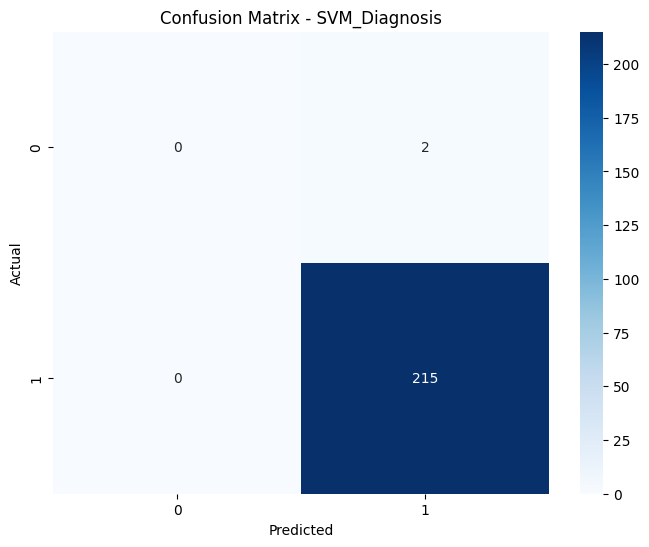

2025-02-07 12:45:04,185 - INFO - 
Model Evaluation Completed for SVM_Diagnosis!
2025-02-07 12:45:04,185 - INFO - Accuracy: 0.9908
2025-02-07 12:45:04,186 - INFO - Confusion Matrix: [[0, 2], [0, 215]]



-------------------- SVM_Stage Results --------------------

Accuracy: 0.5209

Classification Report:
               precision    recall  f1-score   support

           1       0.52      0.98      0.68       113
           2       0.33      0.02      0.03        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.52       215
   macro avg       0.21      0.25      0.18       215
weighted avg       0.37      0.52      0.37       215


Confusion Matrix:
 [[111   2   0   0]
 [ 61   1   0   0]
 [ 35   0   0   0]
 [  5   0   0   0]]

Confusion matrix saved to ../results/svm/svm_stage_confusion_matrix.png


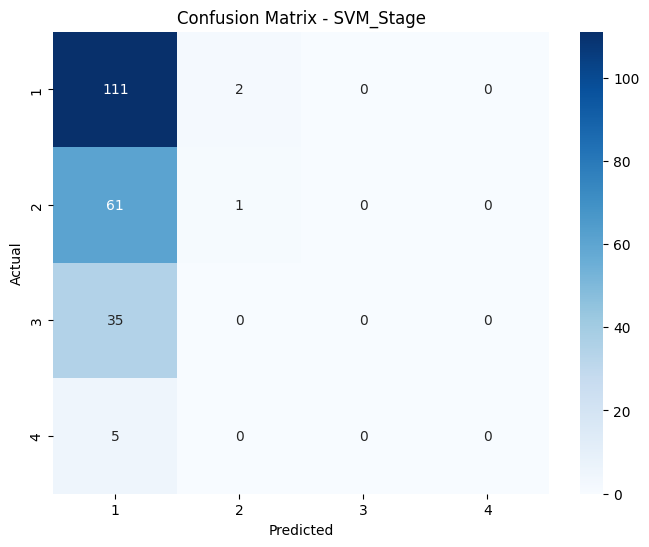

2025-02-07 12:45:04,368 - INFO - 
Model Evaluation Completed for SVM_Stage!
2025-02-07 12:45:04,368 - INFO - Accuracy: 0.5209
2025-02-07 12:45:04,369 - INFO - Confusion Matrix: [[111, 2, 0, 0], [61, 1, 0, 0], [35, 0, 0, 0], [5, 0, 0, 0]]



-------------------- SVM_Subtype Results --------------------

Accuracy: 0.5442

Classification Report:
               precision    recall  f1-score   support

           1       0.56      0.56      0.56       112
           2       0.52      0.52      0.52       103

    accuracy                           0.54       215
   macro avg       0.54      0.54      0.54       215
weighted avg       0.54      0.54      0.54       215


Confusion Matrix:
 [[63 49]
 [49 54]]

Confusion matrix saved to ../results/svm/svm_subtype_confusion_matrix.png


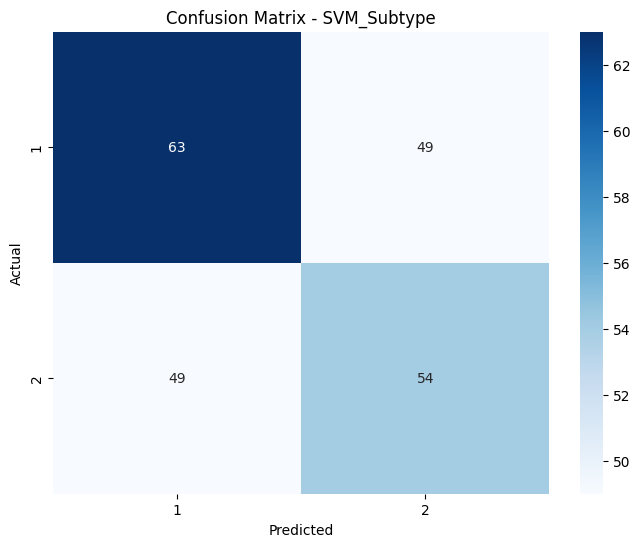

2025-02-07 12:45:04,519 - INFO - 
Model Evaluation Completed for SVM_Subtype!
2025-02-07 12:45:04,520 - INFO - Accuracy: 0.5442
2025-02-07 12:45:04,520 - INFO - Confusion Matrix: [[63, 49], [49, 54]]


In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

def evaluate_model(y_test, y_pred, model_name, save_dir="../results/svm/"):
    """
    Evaluate model performance with accuracy, classification reports, and confusion matrices.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", cm)

    # Visualizations
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    
    # Save the plot
    cm_path = os.path.join(save_dir, f"{model_name.lower()}_confusion_matrix.png")
    plt.savefig(cm_path)
    print(f"\nConfusion matrix saved to {cm_path}")

    plt.show()

    # Log evaluation metrics
    logging.info(f"\nModel Evaluation Completed for {model_name}!")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"Confusion Matrix: {cm.tolist()}")

    return {
        "accuracy": accuracy,
        "confusion_matrix": cm.tolist(),
        "classification_report": report
    }

# Evaluate Diagnosis Model**
metrics_diagnosis = evaluate_model(y_test_diagnosis, y_pred_diagnosis, model_name="SVM_Diagnosis")

# Evaluate Stage Model**
metrics_stage = evaluate_model(y_test_cancer["stage"], y_pred_stage, model_name="SVM_Stage")

# Evaluate Subtype Model**
metrics_subtype = evaluate_model(y_test_cancer["subtype"], y_pred_subtype, model_name="SVM_Subtype")

### Visualize Performance Metrics


Classification Report for Precision, Recall, F1-score - Diagnosis Classification:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       215

    accuracy                           0.99       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.98      0.99      0.99       217

Metrics comparison saved to ../results/svm/plots/diagnosis_metrics_comparison.png


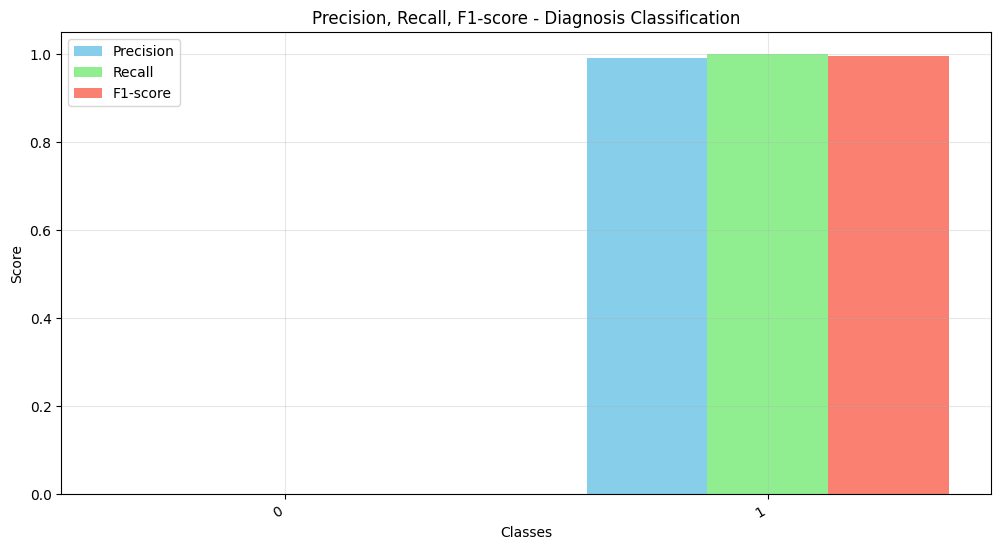


Classification Report for Precision, Recall, F1-score - Stage Classification:

              precision    recall  f1-score   support

           1       0.52      0.98      0.68       113
           2       0.33      0.02      0.03        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.52       215
   macro avg       0.21      0.25      0.18       215
weighted avg       0.37      0.52      0.37       215

Metrics comparison saved to ../results/svm/plots/stage_metrics_comparison.png


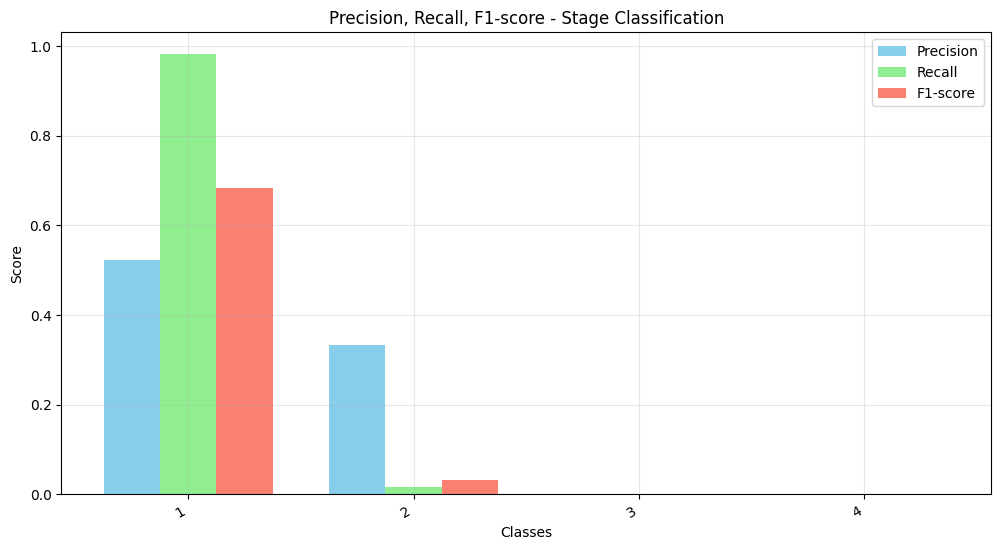


Classification Report for Precision, Recall, F1-score - Subtype Classification:

              precision    recall  f1-score   support

           1       0.56      0.56      0.56       112
           2       0.52      0.52      0.52       103

    accuracy                           0.54       215
   macro avg       0.54      0.54      0.54       215
weighted avg       0.54      0.54      0.54       215

Metrics comparison saved to ../results/svm/plots/subtype_metrics_comparison.png


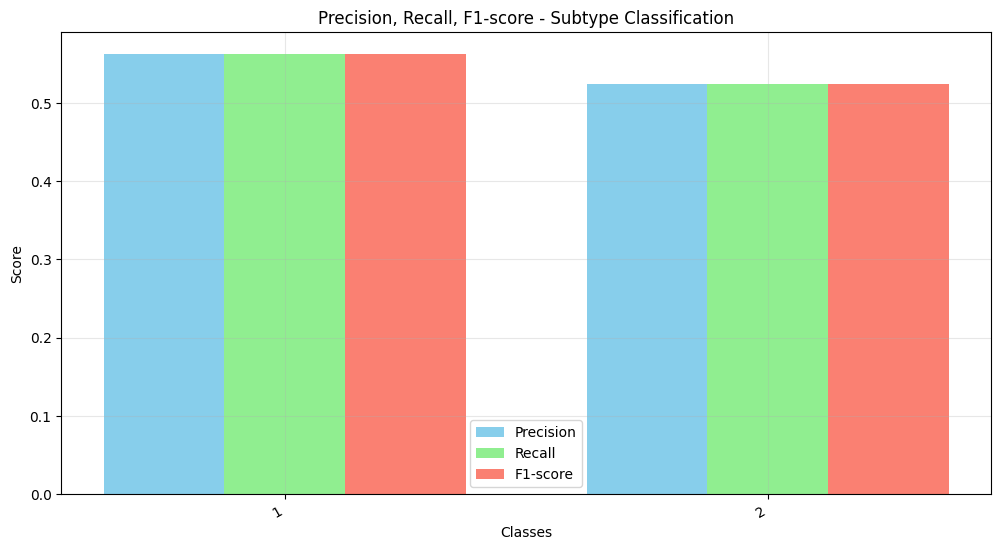

In [14]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define save directory
save_dir = "../results/svm/plots/"
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

def plot_metrics_comparison(y_true, y_pred, labels, title, save_path=None):
    """Plots precision, recall, and F1-score for each class and prints the classification report."""
    report = classification_report(y_true, y_pred, target_names=[str(lbl) for lbl in labels], output_dict=True)
    
    # Restored Print Output
    print(f"\nClassification Report for {title}:\n")
    print(classification_report(y_true, y_pred, target_names=[str(lbl) for lbl in labels]))

    metrics_data = {'Precision': [], 'Recall': [], 'F1-score': []}
    for label in labels:
        label_str = str(label)
        if label_str in report:
            metrics_data['Precision'].append(report[label_str]['precision'])
            metrics_data['Recall'].append(report[label_str]['recall'])
            metrics_data['F1-score'].append(report[label_str]['f1-score'])
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(labels))
    width = 0.25

    plt.bar(x - width, metrics_data['Precision'], width, label='Precision', color='skyblue')
    plt.bar(x, metrics_data['Recall'], width, label='Recall', color='lightgreen')
    plt.bar(x + width, metrics_data['F1-score'], width, label='F1-score', color='salmon')

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(x, labels, rotation=30, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path)
        print(f"Metrics comparison saved to {save_path}")
    plt.show()

# Diagnosis Visualization (Now with Print Output)
diagnosis_labels = sorted(y_test_diagnosis.unique())
plot_metrics_comparison(y_test_diagnosis, y_pred_diagnosis, diagnosis_labels, 
                        "Precision, Recall, F1-score - Diagnosis Classification", 
                        save_path=os.path.join(save_dir, "diagnosis_metrics_comparison.png"))

# Stage Visualization (Now with Print Output)
stage_labels = sorted(y_test_cancer["stage"].unique())
plot_metrics_comparison(y_test_cancer["stage"], y_pred_stage, stage_labels, 
                        "Precision, Recall, F1-score - Stage Classification", 
                        save_path=os.path.join(save_dir, "stage_metrics_comparison.png"))

# Subtype Visualization (Now with Print Output)
subtype_labels = sorted(y_test_cancer["subtype"].unique())
plot_metrics_comparison(y_test_cancer["subtype"], y_pred_subtype, subtype_labels, 
                        "Precision, Recall, F1-score - Subtype Classification", 
                        save_path=os.path.join(save_dir, "subtype_metrics_comparison.png"))

### Save Everything & Finalize the Pipeline

In [15]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory
output_dir = "../results/svm/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Save Predictions & Actual Labels for Diagnosis**
predictions_diagnosis_path = os.path.join(output_dir, "svm_predictions_diagnosis.csv")
pd.DataFrame({"actual": y_test_diagnosis, "predicted": y_pred_diagnosis}).to_csv(predictions_diagnosis_path, index=False)
logging.info(f"Diagnosis predictions saved to {predictions_diagnosis_path}")

# Save Predictions & Actual Labels for Stage**
predictions_stage_path = os.path.join(output_dir, "svm_predictions_stage.csv")
pd.DataFrame({"actual": y_test_cancer["stage"], "predicted": y_pred_stage}).to_csv(predictions_stage_path, index=False)
logging.info(f"Stage predictions saved to {predictions_stage_path}")

# Save Predictions & Actual Labels for Subtype**
predictions_subtype_path = os.path.join(output_dir, "svm_predictions_subtype.csv")
pd.DataFrame({"actual": y_test_cancer["subtype"], "predicted": y_pred_subtype}).to_csv(predictions_subtype_path, index=False)
logging.info(f"Subtype predictions saved to {predictions_subtype_path}")

# Save Experiment Metadata**
metadata = {
    "diagnosis_hyperparameters": grid_diagnosis.best_params_,
    "stage_hyperparameters": grid_stage.best_params_,
    "subtype_hyperparameters": grid_subtype.best_params_,
    "diagnosis_accuracy": metrics_diagnosis["accuracy"],
    "stage_accuracy": metrics_stage["accuracy"],
    "subtype_accuracy": metrics_subtype["accuracy"],
    "train_set_size_diagnosis": X_train_diagnosis.shape[0],
    "train_set_size_stage": X_train_cancer.shape[0],
    "test_set_size_diagnosis": X_test_diagnosis.shape[0],
    "test_set_size_stage": X_test_cancer.shape[0],
}

metadata_path = os.path.join(output_dir, "svm_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")

# **5️ Save Trained Models**
model_diagnosis_path = os.path.join(output_dir, "svm_model_diagnosis.pkl")
joblib.dump(best_svm_diagnosis, model_diagnosis_path)
logging.info(f"Diagnosis model saved to {model_diagnosis_path}")

model_stage_path = os.path.join(output_dir, "svm_model_stage.pkl")
joblib.dump(best_svm_stage, model_stage_path)
logging.info(f"Stage model saved to {model_stage_path}")

model_subtype_path = os.path.join(output_dir, "svm_model_subtype.pkl")
joblib.dump(best_svm_subtype, model_subtype_path)
logging.info(f"Subtype model saved to {model_subtype_path}")

print("\n All results successfully saved. The SVM pipeline is complete!")

2025-02-07 12:45:15,560 - INFO - Diagnosis predictions saved to ../results/svm/svm_predictions_diagnosis.csv
2025-02-07 12:45:15,562 - INFO - Stage predictions saved to ../results/svm/svm_predictions_stage.csv
2025-02-07 12:45:15,564 - INFO - Subtype predictions saved to ../results/svm/svm_predictions_subtype.csv
2025-02-07 12:45:15,565 - INFO - Metadata saved to ../results/svm/svm_metadata.json
2025-02-07 12:45:15,568 - INFO - Diagnosis model saved to ../results/svm/svm_model_diagnosis.pkl
2025-02-07 12:45:15,571 - INFO - Stage model saved to ../results/svm/svm_model_stage.pkl
2025-02-07 12:45:15,575 - INFO - Subtype model saved to ../results/svm/svm_model_subtype.pkl



 All results successfully saved. The SVM pipeline is complete!
